# Transformer 
---

## 1. STRIP for defending backdoor poisoning attacks

### API Reference:
- https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/transformer_poisoning.html#strip

### Related paper:
- https://arxiv.org/abs/1902.06531

---

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution() # To use the ART
tf.get_logger().setLevel('ERROR')

import tensorflow.keras as tk
import tensorflow.keras.layers as tkl
from tensorflow.keras import datasets, layers, models, Sequential
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout

import matplotlib.pyplot as plt
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence
from art.defences.transformer.poisoning import STRIP

mnist_model_path = '/archive/workspace/TTA/demo/models/baisc_cnn_mnist'

### Load dataset (MNIST)

In [ ]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Generate poisoning data

In [ ]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [ ]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources = np.arange(10)
    targets = np.array([1] * 10)
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [ ]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

### Train model with poisoned dataset

In [ ]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-12-21 14:33:00.913168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:33:00.913747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:33:00.917405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:33:00.917955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:33:00.918485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

Train on 11640 samples


2021-12-21 14:33:11.348251: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 14:33:11.512507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:33:11.513227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-21 14:33:11.513853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/3


2021-12-21 14:33:12.662133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


11640/11640 [==============================] - 2s 168us/sample - loss: 0.7672 - accuracy: 0.7515
Epoch 2/3
11640/11640 [==============================] - 1s 72us/sample - loss: 0.2137 - accuracy: 0.9370
Epoch 3/3
11640/11640 [==============================] - 2s 168us/sample - loss: 0.7672 - accuracy: 0.7515
Epoch 2/3
11640/11640 [==============================] - 1s 72us/sample - loss: 0.2137 - accuracy: 0.9370
Epoch 3/3
11008/11640 [===========================>..] - ETA: 0s - loss: 0.1423 - accuracy: 0.957711640/11640 [==============================] - 2s 168us/sample - loss: 0.7672 - accuracy: 0.7515
Epoch 2/3
11640/11640 [==============================] - 1s 72us/sample - loss: 0.2137 - accuracy: 0.9370
Epoch 3/3
10240/11640 [=========================>....] - ETA: 0s - loss: 0.1415 - accuracy: 0.957111640/11640 [==============================] - 2s 168us/sample - loss: 0.7672 - accuracy: 0.7515
Epoch 2/3
11640/11640 [==============================] - 1s 72us/sample - loss: 0.2137 -

### Evaluate the model
#### Evaluate the model with original samples


Clean test set accuracy: 96.85%


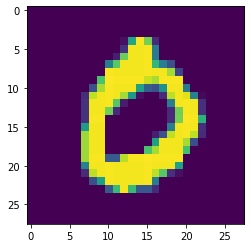

Prediction: 0


In [ ]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

#### Evaluate the model with poisoning samples

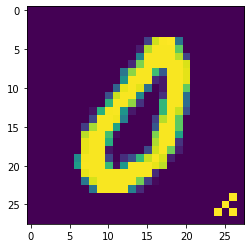

Prediction: 1

 Effectiveness of poison: 100.00%


In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

#### Evaluate accuracy on entire test set

In [ ]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy (i.e. effectiveness of poison): %.2f%%" % (total_acc * 100))


 Overall test set accuracy (i.e. effectiveness of poison): 97.98%


### Filter Poison Using STRIP

Same as Spectral Signatures procedure until model training and adversarial example generation

In [ ]:
strip = STRIP(classifier)
defence = strip()
defence.mitigate(clean_x_test[:100])

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
poison_preds = defence.predict(poison_x_test)
clean_preds = defence.predict(clean_x_test[100:])

num_abstained_poison = np.sum(np.all(poison_preds == np.zeros(10),axis=1))
num_abstained_clean = np.sum(np.all(clean_preds == np.zeros(10),axis=1))
num_poison = len(poison_preds)
num_clean = len(clean_preds)

print(f"Abstained {num_abstained_poison}/{num_poison} poison samples ({round(num_abstained_poison / float(num_poison)* 100, 2)}% TP rate)")
print(f"Abstained {num_abstained_clean}/{num_clean} clean samples ({round(num_abstained_clean / float(num_clean) * 100, 2)}% FP rate)")

Abstained 1314/5590 poison samples (23.51% TP rate)
Abstained 83/9900 clean samples (0.84% FP rate)


--- 

## 2. Neural Cleanse

### API Reference:
- https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/transformer_poisoning.html#neural-cleanse

### Related paper:
- https://people.cs.uchicago.edu/~ravenben/publications/pdf/backdoor-sp19.pdf

--- 

### Build and train model with MNIST

In [ ]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

Train on 11640 samples
Epoch 1/3
11640/11640 [==============================] - 1s 81us/sample - loss: 0.6851 - accuracy: 0.7752
Epoch 2/3
11640/11640 [==============================] - 1s 76us/sample - loss: 0.1740 - accuracy: 0.9491
Epoch 3/3
11640/11640 [==============================] - 1s 75us/sample - loss: 0.1147 - accuracy: 0.9669


### Evaluate the model with poisoning sample (Backdoor attack)

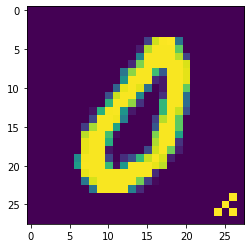

Prediction: 1

 Effectiveness of poison: 100.00%


In [ ]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

#### Evaluate accuracy on entire test set

In [ ]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy: %.2f%%" % (total_acc * 100))


 Overall test set accuracy: 97.98%


### Apply NeuralCleanse

In [ ]:
from art.defences.transformer.poisoning import NeuralCleanse

cleanse = NeuralCleanse(classifier)
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)

### Identifying the Backdoor

Unlike most defenses, part of the procedure for this defense is identifying exactly what the suspected backdoor is for each class. 
Below is the _reverse-engineered backdoor_. This will be appended to clean images to mimic backdoor behavior

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

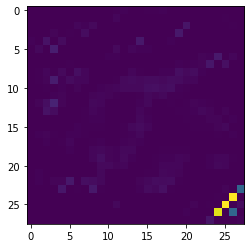

In [25]:
pattern, mask = defence_cleanse.generate_backdoor(x_test, y_test, np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
plt.imshow(np.squeeze(mask * pattern))

Usually `generate_backdoor` is called as a result of calling `mitigate`. During this process, this defense **_generates a suspected backdoor for each class_**  visualized above. The `mitigate` method also performs the mitigation types presented below.

### Mitigation Types

There are different mitigation methods that are described below.

#### Filtering

Filtering is the process of abstaining from potentially poisonous predictions at runtime. When this method is set, neurons are ranked by their association with the backdoor, and when neural activations are higher than normal, the classifier abstains from predication (output is all zeros).

In [26]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["filtering"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
poison_pred = defence_cleanse.predict(poison_x_test)
num_filtered = np.sum(np.all(poison_pred == np.zeros(10), axis=1))
num_poison = len(poison_pred)
effectiveness = float(num_filtered) / num_poison * 100
print("Filtered {}/{} poison samples ({:.2f}% effective)".format(num_filtered, num_poison, effectiveness))

Filtered 5176/5590 poison samples (92.59% effective)


#### Unlearning

Unlearning is the process of _retraining the backdoors with the correct label for one epoch_. This works best for Trojan-style triggers that react to a specific neuron configuration.

In [28]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["unlearning"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

Train on 3147 samples
3147/3147 [==============================] - 11s 4ms/sample - loss: 0.0125 - accuracy: 0.9981


In [34]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after unlearning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after unlearning: 91.95% (previously 100.00%)

 Clean test set accuracy: 29.64% (previously 96.85%)


#### Pruning

Pruning is the process of _zero-ing out neurons strongly associated with backdoor behavior_ until the backdoor is ineffective or 30% of all neurons have been pruned. Be careful as this can negatively affect the accuracy of your model. This works best for fully mitigating the effects of backdoor poisoning attacks.

In [30]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after pruning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after pruning: 91.95% (previously 100.00%)

 Clean test set accuracy: 29.64% (previously 96.85%)


#### Combination

Finally, you can also do a combination of any of the above mitigation methods to fit your needs. Just add those types to the `mitigation_types` list.

In [32]:
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning", "filtering"])

Generating backdoor for class 0:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 1:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 2:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 3:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 4:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 5:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 6:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 7:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 8:   0%|          | 0/10 [00:00<?, ?it/s]

Generating backdoor for class 9:   0%|          | 0/10 [00:00<?, ?it/s]

In [33]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after pruning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after pruning: 91.95% (previously 100.00%)

 Clean test set accuracy: 29.64% (previously 96.85%)
